In [1]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')  # 加载'ggplot'风格
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

import sqlite3
import csv

from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests


from joblib import Parallel,delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# HSTECH = pd.read_excel('HSTECH.xlsx')
# HSTECH = HSTECH[HSTECH['日期'].notna()]
# HSTECH.drop(labels=['代码','名称','成交量(股)'], axis=1, inplace=True)
# HSTECH = HSTECH.iloc[1:].set_index('日期')
# HSTECH['DAY'] = HSTECH.index.map(lambda x: datetime.datetime(x.year, x.month, x.day))
# HSTECH.reset_index(inplace=True)
# HSTECH.sort_values(by=['DAY','日期'], inplace=True)

In [3]:
# fig, ax = plt.subplots(5,1, figsize=(10, 5), sharex=True)
# ax[0].plot(HSTECH_ts.index,HSTECH_ts['开盘价(元)'], label='开盘价(元)')
# ax[1].plot(HSTECH_ts.index,HSTECH_ts['最高价(元)'], label='最高价(元)')
# ax[2].plot(HSTECH_ts.index,HSTECH_ts['最低价(元)'], label='最低价(元)')
# ax[3].plot(HSTECH_ts.index,HSTECH_ts['收盘价(元)'], label='收盘价(元)')
# ax[4].plot(HSTECH_ts.index,HSTECH_ts['成交额(百万)'], label='成交额(百万)')
# ax[0].set_title('开盘价(元)')
# ax[1].set_title('最高价(元)')
# ax[2].set_title('最低价(元)')
# ax[3].set_title('收盘价(元)')
# ax[4].set_title('成交额(百万)')
# plt.tight_layout()  # 调整子图之间的间距以最小化重叠

In [4]:
# day = datetime.datetime(2022, 12, 12)
# HSTECH_ts_t = HSTECH_ts[HSTECH_ts['DAY']==day]
# start_hm = datetime.datetime(day.year,day.month,day.day,14,45,0)
# end_hm = datetime.datetime(day.year,day.month,day.day,15,15,0)
# HSTECH_ts_t = HSTECH_ts_t[(HSTECH_ts_t.index>=start_hm)&(HSTECH_ts_t.index<=end_hm)]
# fig, ax = plt.subplots(5,1, figsize=(10, 5), sharex=True)
# ax[0].plot(HSTECH_ts_t.index,HSTECH_ts_t['开盘价(元)'], label='开盘价(元)')
# ax[1].plot(HSTECH_ts_t.index,HSTECH_ts_t['最高价(元)'], label='最高价(元)')
# ax[2].plot(HSTECH_ts_t.index,HSTECH_ts_t['最低价(元)'], label='最低价(元)')
# ax[3].plot(HSTECH_ts_t.index,HSTECH_ts_t['收盘价(元)'], label='收盘价(元)')
# ax[4].plot(HSTECH_ts_t.index,HSTECH_ts_t['成交额(百万)'], label='成交额(百万)')
# ax[0].set_title('开盘价(元)')
# ax[1].set_title('最高价(元)')
# ax[2].set_title('最低价(元)')
# ax[3].set_title('收盘价(元)')
# ax[4].set_title('成交额(百万)')
# ax[0].axvline(x=datetime.datetime(day.year,day.month,day.day,15,0,0), linestyle=":", color="m")
# ax[1].axvline(x=datetime.datetime(day.year,day.month,day.day,15,0,0), linestyle=":", color="m")
# ax[2].axvline(x=datetime.datetime(day.year,day.month,day.day,15,0,0), linestyle=":", color="m")
# ax[3].axvline(x=datetime.datetime(day.year,day.month,day.day,15,0,0), linestyle=":", color="m")
# ax[4].axvline(x=datetime.datetime(day.year,day.month,day.day,15,0,0), linestyle=":", color="m")
# plt.tight_layout()  # 调整子图之间的间距以最小化重叠

In [5]:
# HSTECH_ts = pd.read_excel('HSTECH_2.xlsx').loc[4:]
# HSTECH_ts.columns = ['日期','收盘价(元)']
# HSTECH_ts['DAY'] = HSTECH_ts['日期'].map(lambda x: datetime.datetime(x.year, x.month, x.day))
# HSTECH_ts.sort_values(by=['DAY','日期'], inplace=True)

In [6]:
HSTECH_ts = pd.read_excel('HS_TECH_15min.xlsx')[['日期','收盘价(元)']].iloc[:-2]
HSTECH_ts['DAY'] = HSTECH_ts['日期'].map(lambda x: datetime.datetime(x.year, x.month, x.day))
HSTECH_ts = HSTECH_ts[HSTECH_ts['DAY']!=datetime.datetime(2021, 5, 21)]
HSTECH_ts.sort_values(by=['DAY','日期'], inplace=True)

In [7]:
HSTECH_ts

,日期,收盘价(元),DAY
4,2021-05-24 09:45:00,7877.05,2021-05-24
5,2021-05-24 10:00:00,7869.91,2021-05-24
6,2021-05-24 10:15:00,7803.63,2021-05-24
7,2021-05-24 10:30:00,7813.71,2021-05-24
8,2021-05-24 10:45:00,7826.87,2021-05-24
...,...,...,...
10298,2023-04-20 15:00:00,4108.86,2023-04-20
10299,2023-04-20 15:15:00,4102.63,2023-04-20
10300,2023-04-20 15:30:00,4099.43,2023-04-20
10301,2023-04-20 15:45:00,4091.31,2023-04-20


In [8]:
len(set(HSTECH_ts['DAY']))

471

# 2 指定时刻的前后差异对比
- 描述性统计
- t检验
- anova分析（ANOVA是一套分析分析方法用来解决：多组样本之间的平均数是否有显著的不同https://www.zhihu.com/question/320487814）
    - 单因素方差分析认为如果组间方差大于组内方差，几组样本的平均值是有区别的
    - 但是一般用于三个以上样本组，并检查哪个样本明显区别于其他样本
- Mann-Whitney U检验用于比较两个样本组的中位数是否存在差异

In [9]:
# 按天统计指定时间区间的收益
def cal_rets_diff(dfGrouped, length):
    t = dfGrouped['日期'].iloc[0]
    hm15 = datetime.datetime(t.year,t.month,t.day,15,0,0)

    dfGrouped1 = dfGrouped[dfGrouped['日期']<=hm15].iloc[-(length+2):]
    dfGrouped2 = dfGrouped[dfGrouped['日期']>=hm15].iloc[:length+2]
    if len(dfGrouped1) & len(dfGrouped2):
        dfGrouped1_start_close_price = dfGrouped1['收盘价(元)'].iloc[0]
        dfGrouped1_end_close_price = dfGrouped1['收盘价(元)'].iloc[-1]
        dfGrouped2_start_close_price = dfGrouped2['收盘价(元)'].iloc[0]
        dfGrouped2_end_close_price = dfGrouped2['收盘价(元)'].iloc[-1]
        dfGrouped1_ret = (dfGrouped1_end_close_price-dfGrouped1_start_close_price)/dfGrouped1_start_close_price
        dfGrouped2_ret = (dfGrouped2_end_close_price-dfGrouped2_start_close_price)/dfGrouped2_start_close_price
    else:
        dfGrouped1_ret = np.NaN
        dfGrouped2_ret = np.NaN
    
    return [dfGrouped1_ret, dfGrouped2_ret]

In [10]:
winodw_length = 40

ret_before_describe = pd.DataFrame()
ret_after_describe = pd.DataFrame()
ret_diff_describe = pd.DataFrame()
ret_oneway_anova = pd.DataFrame()
ret_mannwhitneyu = pd.DataFrame()
for length in range(winodw_length):
    _df = pd.DataFrame()
#     _ser = HSTECH_ts[HSTECH_ts['DAY']>=datetime.datetime(2022,12,12)].groupby('DAY').apply(cal_rets_diff, length)
    _ser = HSTECH_ts.groupby('DAY').apply(cal_rets_diff, length)
    _df['ret_before'] = _ser.map(lambda x: x[0])
    _df['ret_after'] = _ser.map(lambda x: x[1])
    _df.dropna(how='any', inplace=True)
    # 1.ret_before描述性统计
    describe = _df['ret_before'].describe()
    ret_before_describe.loc[length+1, 'count'] = describe.loc['count']
    ret_before_describe.loc[length+1, 'mean'] = describe.loc['mean']
    ret_before_describe.loc[length+1, 'std'] = describe.loc['std']
    ret_before_describe.loc[length+1, 'min'] = describe.loc['min']
    ret_before_describe.loc[length+1, '25%'] = describe.loc['25%']
    ret_before_describe.loc[length+1, '50%'] = describe.loc['50%']
    ret_before_describe.loc[length+1, '75%'] = describe.loc['75%']
    ret_before_describe.loc[length+1, 'max'] = describe.loc['max']
    # 2.单边检验显著性计算
    t0, p0 = stats.ttest_1samp(_df['ret_before'],0)
    ret_before_describe.loc[length+1, 'p'] = round(p0, 4)
    t1, p1 = stats.ttest_1samp(_df['ret_before'],0, alternative='less')
    ret_before_describe.loc[length+1, 'p_lhs'] = round(p1, 4)
    t2, p2 = stats.ttest_1samp(_df['ret_before'],0, alternative='greater')
    ret_before_describe.loc[length+1, 'p_rhs'] = round(p2, 4)
    # 3.区间取得正收益的比率
    positive_ratio = sum(_df['ret_before']>0)/len(_df['ret_before'])
    ret_before_describe.loc[length+1, 'positive_ratio'] = round(positive_ratio, 4)
    
    # ret_after描述性统计
    describe = _df['ret_after'].describe()
    ret_after_describe.loc[length+1, 'count'] = describe.loc['count']
    ret_after_describe.loc[length+1, 'mean'] = describe.loc['mean']
    ret_after_describe.loc[length+1, 'std'] = describe.loc['std']
    ret_after_describe.loc[length+1, 'min'] = describe.loc['min']
    ret_after_describe.loc[length+1, '25%'] = describe.loc['25%']
    ret_after_describe.loc[length+1, '50%'] = describe.loc['50%']
    ret_after_describe.loc[length+1, '75%'] = describe.loc['75%']
    ret_after_describe.loc[length+1, 'max'] = describe.loc['max']
    # 单边检验显著性计算
    t0, p0 = stats.ttest_1samp(_df['ret_after'],0)
    ret_after_describe.loc[length+1, 'p'] = round(p0, 4)
    t1, p1 = stats.ttest_1samp(_df['ret_after'],0, alternative='less')
    ret_after_describe.loc[length+1, 'p_lhs'] = round(p1, 4)
    t2, p2 = stats.ttest_1samp(_df['ret_after'],0, alternative='greater')
    ret_after_describe.loc[length+1, 'p_rhs'] = round(p2, 4)
    # 区间取得正收益的比率
    positive_ratio = sum(_df['ret_after']>0)/len(_df['ret_after'])
    ret_after_describe.loc[length+1, 'positive_ratio'] = round(positive_ratio, 4)
    
    _df['ret_diff'] = _df['ret_after'] - _df['ret_before']
    # ret_diff描述性统计
    describe = _df['ret_diff'].describe()
    ret_diff_describe.loc[length+1, 'count'] = describe.loc['count']
    ret_diff_describe.loc[length+1, 'mean'] = describe.loc['mean']
    ret_diff_describe.loc[length+1, 'std'] = describe.loc['std']
    ret_diff_describe.loc[length+1, 'min'] = describe.loc['min']
    ret_diff_describe.loc[length+1, '25%'] = describe.loc['25%']
    ret_diff_describe.loc[length+1, '50%'] = describe.loc['50%']
    ret_diff_describe.loc[length+1, '75%'] = describe.loc['75%']
    ret_diff_describe.loc[length+1, 'max'] = describe.loc['max']
    # 单边检验显著性计算
    t0, p0 = stats.ttest_1samp(_df['ret_diff'],0)
    ret_diff_describe.loc[length+1, 'p'] = round(p0, 4)
    t1, p1 = stats.ttest_1samp(_df['ret_diff'],0, alternative='less')
    ret_diff_describe.loc[length+1, 'p_lhs'] = round(p1, 4)
    t2, p2 = stats.ttest_1samp(_df['ret_diff'],0, alternative='greater')
    ret_diff_describe.loc[length+1, 'p_rhs'] = round(p2, 4)
    # 区间取得正收益的比率
    positive_ratio = sum(_df['ret_after']>0)/len(_df['ret_after'])
    ret_diff_describe.loc[length+1, 'positive_ratio'] = round(positive_ratio, 4)
    
    # 执行单因素方差分析
    fvalue, pvalue = stats.f_oneway(_df['ret_after'], _df['ret_before'])
    ret_oneway_anova.loc[length+1, 'p_oneway_anova'] = round(pvalue, 4)
    
    # 执行Mann-Whitney U检验，比较两个样本组的中位数是否存在差异，alternative='greater'，用于检验第一个样本组的观测值是否大于第二个样本组
    statistic, p_value = stats.mannwhitneyu(_df['ret_after'], _df['ret_before'], alternative='greater')
    ret_mannwhitneyu.loc[length+1, 'p_mannwhitneyu'] = round(p_value, 4)

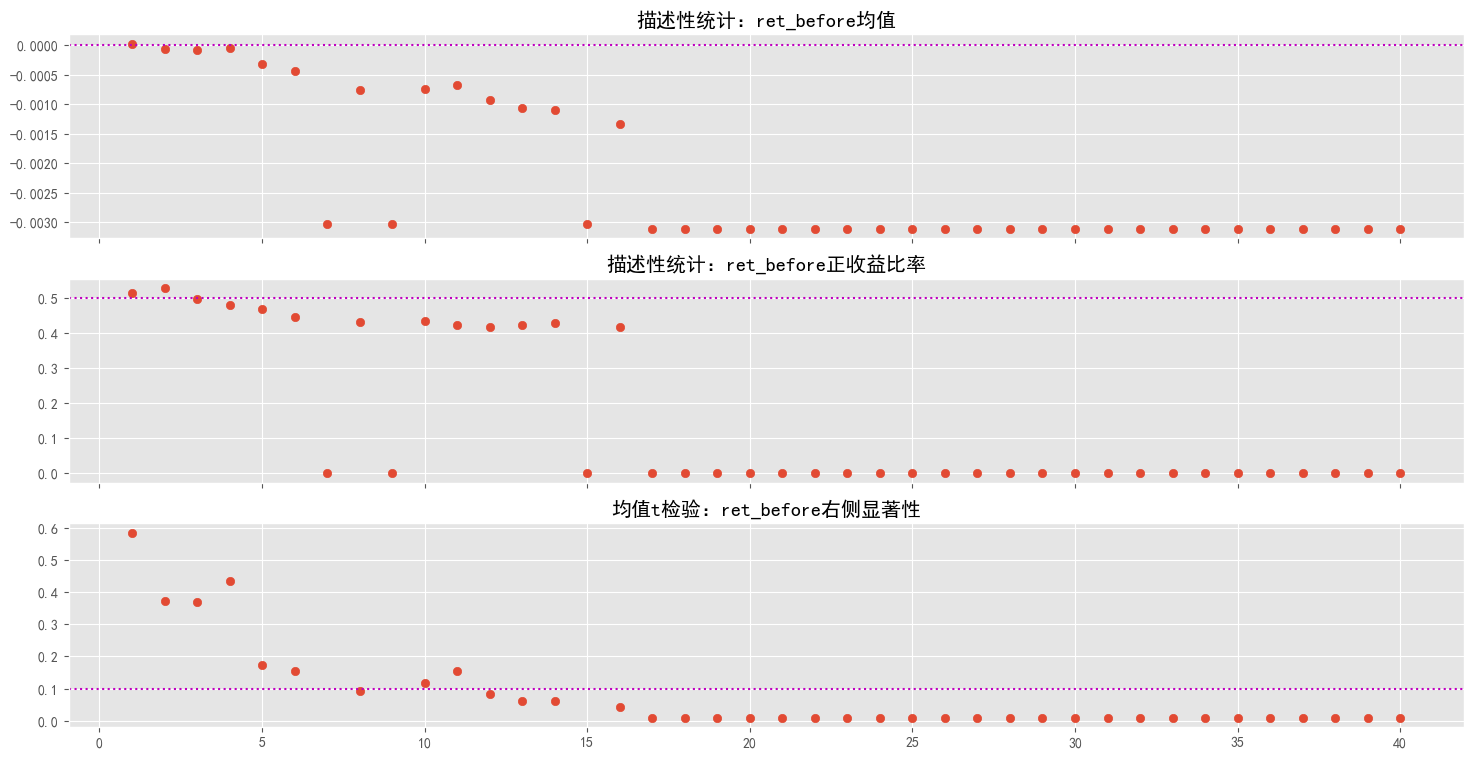

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(18, 9), sharex=True)

plt.subplot(311)
plt.scatter(ret_before_describe.index, ret_before_describe['mean'])
plt.title('描述性统计：ret_before均值')
plt.axhline(y=0, linestyle=":", color="m")

plt.subplot(312)
plt.scatter(ret_before_describe.index, ret_before_describe['positive_ratio'])
plt.title('描述性统计：ret_before正收益比率')
plt.axhline(y=0.5, linestyle=":", color="m")

plt.subplot(313)
plt.scatter(ret_before_describe.index, ret_before_describe['p_lhs'])
plt.title('均值t检验：ret_before右侧显著性')
plt.axhline(y=0.1, linestyle=":", color="m")

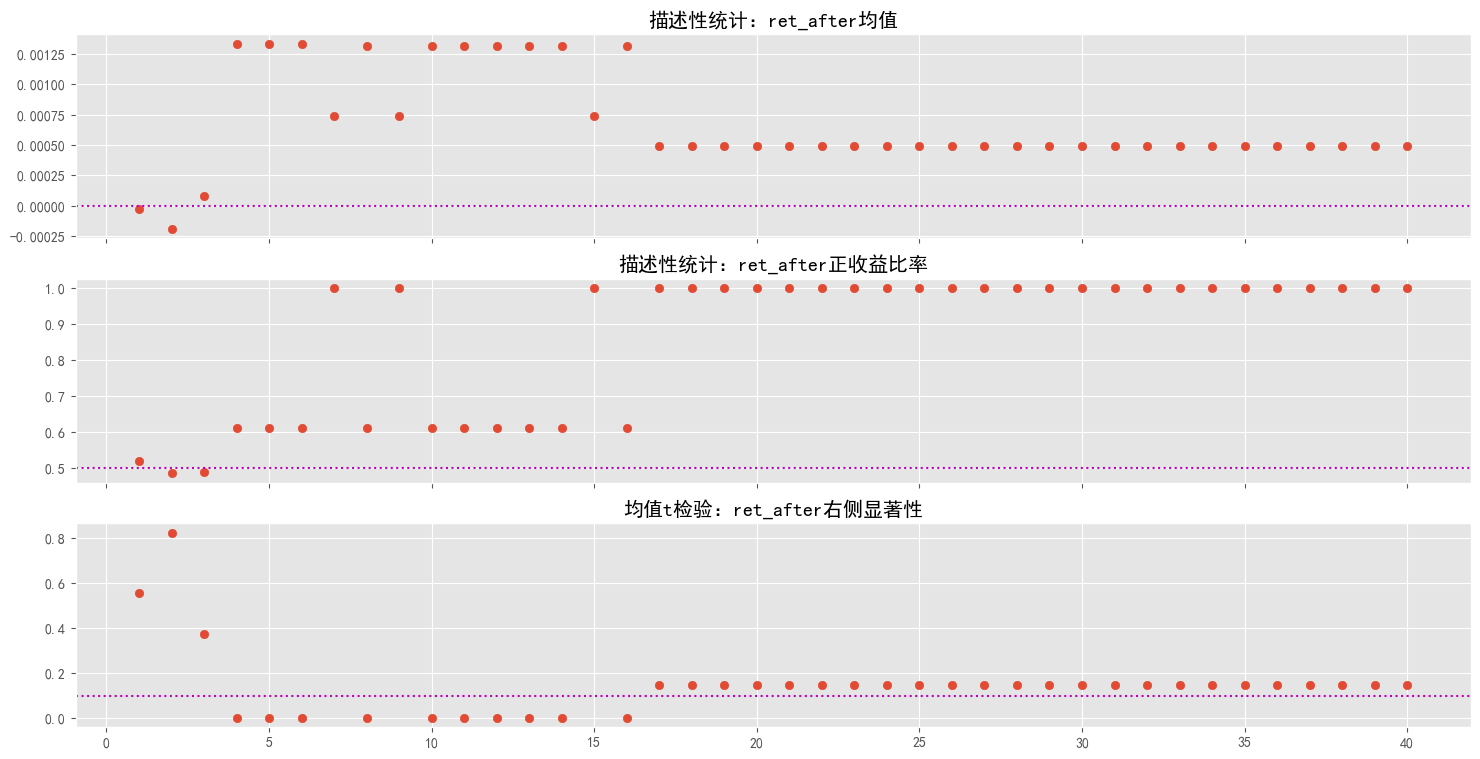

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(18, 9), sharex=True)

plt.subplot(311)
plt.scatter(ret_after_describe.index, ret_after_describe['mean'])
plt.title('描述性统计：ret_after均值')
plt.axhline(y=0, linestyle=":", color="m")

plt.subplot(312)
plt.scatter(ret_after_describe.index, ret_after_describe['positive_ratio'])
plt.title('描述性统计：ret_after正收益比率')
plt.axhline(y=0.5, linestyle=":", color="m")

plt.subplot(313)
plt.scatter(ret_after_describe.index, ret_after_describe['p_rhs'])
plt.title('均值t检验：ret_after右侧显著性')
plt.axhline(y=0.1, linestyle=":", color="m")

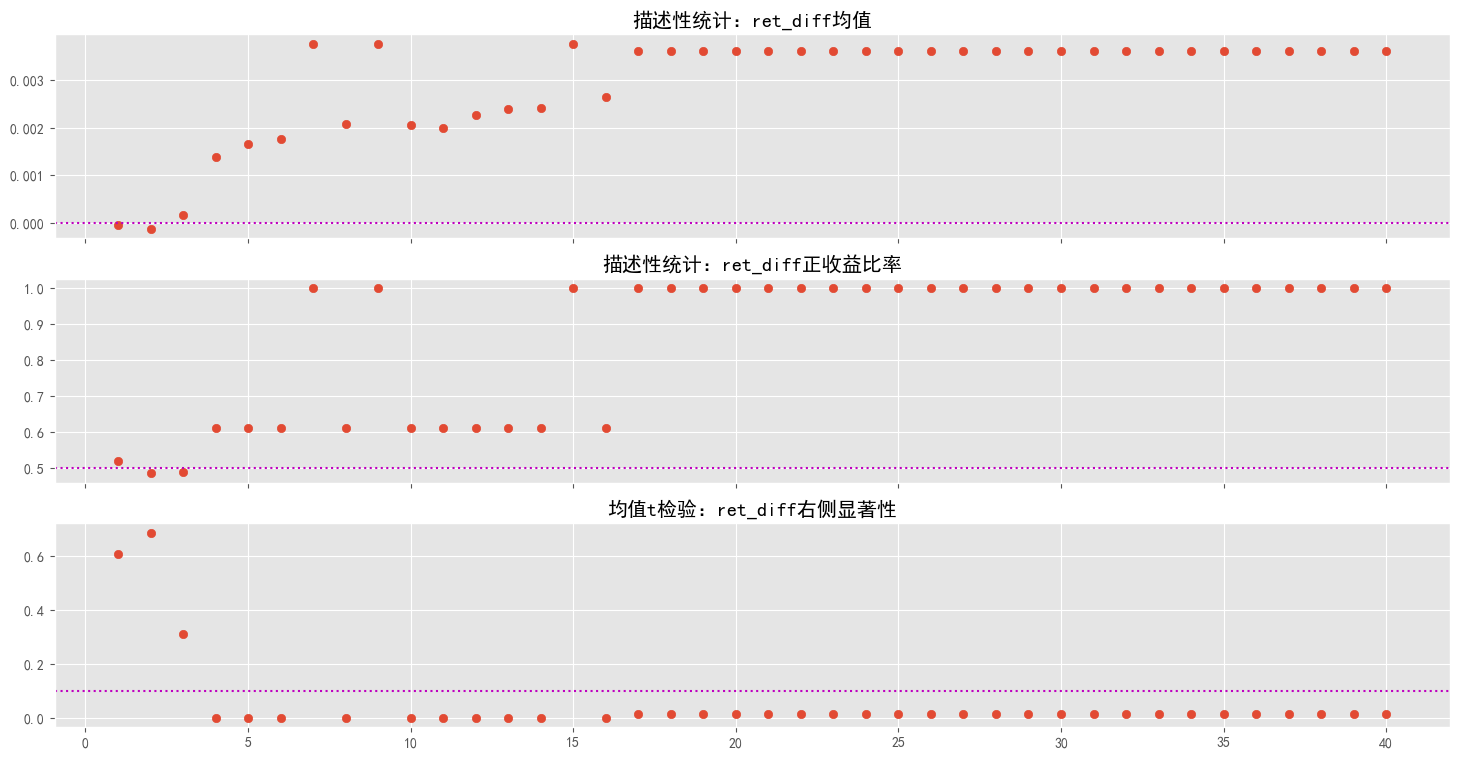

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(18, 9), sharex=True)

plt.subplot(311)
plt.scatter(ret_diff_describe.index, ret_diff_describe['mean'])
plt.title('描述性统计：ret_diff均值')
plt.axhline(y=0, linestyle=":", color="m")

plt.subplot(312)
plt.scatter(ret_diff_describe.index, ret_diff_describe['positive_ratio'])
plt.title('描述性统计：ret_diff正收益比率')
plt.axhline(y=0.5, linestyle=":", color="m")

plt.subplot(313)
plt.scatter(ret_diff_describe.index, ret_diff_describe['p_rhs'])
plt.title('均值t检验：ret_diff右侧显著性')
plt.axhline(y=0.1, linestyle=":", color="m")

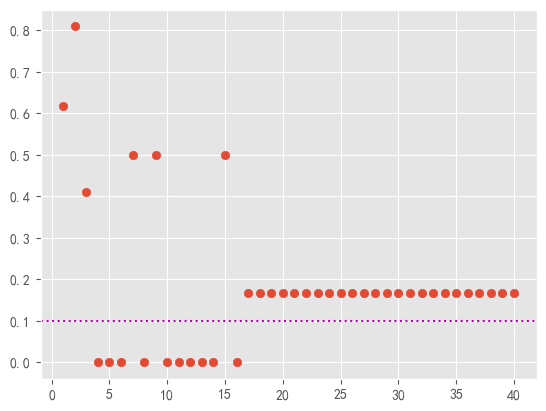

In [14]:
plt.scatter(ret_mannwhitneyu.index, ret_mannwhitneyu['p_mannwhitneyu'])
plt.axhline(y=0.1, linestyle=":", color="m")

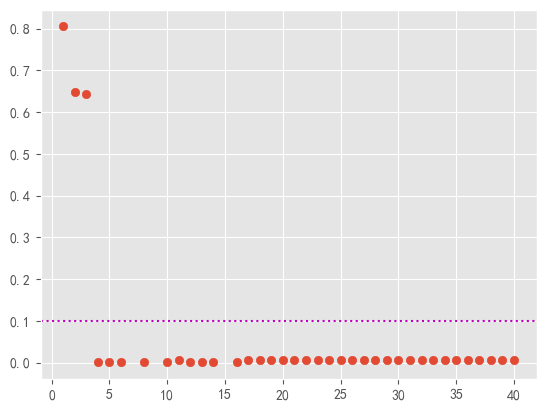

In [15]:
plt.scatter(ret_oneway_anova.index, ret_oneway_anova['p_oneway_anova'])
plt.axhline(y=0.1, linestyle=":", color="m")

# 3 收益估算

In [16]:
len(set(HSTECH_ts['DAY']))

471

In [17]:
def cal_buysell_ret(dfGrouped, hm_lst, commission):
    """length是持仓bar的长度，最小是1
    """
    t = dfGrouped['日期'].iloc[0]
    hm = datetime.datetime(t.year,t.month,t.day,hm_lst[0],hm_lst[1],0)
    dfGrouped2 = dfGrouped[dfGrouped['日期']>=hm]
    if len(dfGrouped2):
        buy_price = dfGrouped2['收盘价(元)'].iloc[0] * (1+commission)
        sell_price = dfGrouped2['收盘价(元)'].iloc[-2] * (1-commission)
        ret = sell_price/buy_price - 1
    else:
        print(t)
        ret = np.NaN
    return ret

In [18]:
hm_lst = [15,0]
commission = 0.0002

2021-12-24 09:45:00
2021-12-31 09:45:00
2022-01-31 09:45:00
2022-11-02 09:45:00
期间净值波动： 0.05526054226668199
期间累计收益： -14.54 %
年化收益： -7.69 %
最大回撤： 19.95 %
shape ratio： -3.17413261191825
收益回撤比： -0.7288708414142453


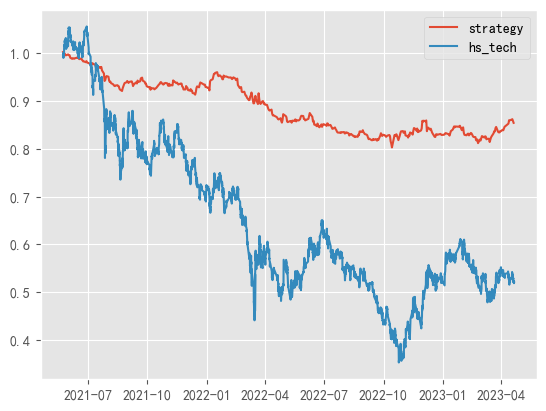

In [19]:
ret_ts = HSTECH_ts.groupby('DAY').apply(cal_buysell_ret, hm_lst, commission)
ret_ts.fillna(0, inplace=True)
cum_ret = np.cumprod(ret_ts + 1)
day_ret = pow(cum_ret.iloc[-1],1/len(ret_ts)) - 1
year_ret = pow(1+day_ret,240) - 1
# 进行最大回撤计算
peak = np.maximum.accumulate(cum_ret)
drawdowns = (peak - cum_ret) / peak
max_drawdown = np.amax(drawdowns)
print('期间净值波动：', cum_ret.std())
print('期间累计收益：', round((cum_ret.iloc[-1]-1)*100,2), '%')
print('年化收益：', round(year_ret*100,2), '%')
print('最大回撤：', round(max_drawdown*100,2), '%')
print('shape ratio：', ((cum_ret.iloc[-1]-1)-0.03)/cum_ret.std())
print('收益回撤比：', (cum_ret.iloc[-1]-1)/max_drawdown)

plt.plot(cum_ret.index, cum_ret, label = 'strategy')
plt.plot(HSTECH_ts['日期'], HSTECH_ts['收盘价(元)']/HSTECH_ts['收盘价(元)'].iloc[0], label = 'hs_tech')
plt.legend(loc="best")

# 4 潜在可能性的验证
- 持有到当天最后时刻卖出的回测效果要好于持有短时间（可能是市场行为是个缓慢持续的过程）
- 借助一些买入信号来动态调整入场时间
- 借助一些风险度信号来衡量当天是否入场

In [20]:
HSTECH_ohlc = pd.read_excel('HSTECH.xlsx')
HSTECH_ohlc = HSTECH_ohlc[HSTECH_ohlc['日期'].notna()]
HSTECH_ohlc.drop(labels=['代码','名称','成交量(股)'], axis=1, inplace=True)
HSTECH_ohlc = HSTECH_ohlc.iloc[1:].set_index('日期')
HSTECH_ohlc['DAY'] = HSTECH_ohlc.index.map(lambda x: datetime.datetime(x.year, x.month, x.day))
HSTECH_ohlc.reset_index(inplace=True)
HSTECH_ohlc.sort_values(by=['DAY','日期'], inplace=True)

In [25]:
def cal_buysell_ret_dynamically(dfGrouped, commission):
    """length是持仓bar的长度，最小是1
    """
    t = dfGrouped['日期'].iloc[0]
    
    # 当前量是否突破均线的量（替代方案用价格波动），均线设为10分钟均线，应该shift对齐避免未来函数
#     dfGrouped['close_price_ma20'] = dfGrouped['收盘价(元)'].rolling(20).mean().shift()
#     dfGrouped['close_price_ma10'] = dfGrouped['收盘价(元)'].rolling(10).mean().shift()
#     dfGrouped['close_price_ma5'] = dfGrouped['收盘价(元)'].rolling(5).mean().shift()
#     dfGrouped['close_price_std15'] = dfGrouped['收盘价(元)'].rolling(15).std().shift()
#     dfGrouped['close_price_std5'] = dfGrouped['收盘价(元)'].rolling(5).std().shift()
#     dfGrouped['volume_ma15'] = dfGrouped['成交额(百万)'].rolling(15).mean().shift()
#     dfGrouped['volume_ma5'] = dfGrouped['成交额(百万)'].rolling(5).mean().shift()
    dfGrouped.dropna(how='any', inplace=True)
    
    # 时间区间设置为14:50-15:10，用该区间切片
    start_timestamp = datetime.datetime(t.year,t.month,t.day, 15, 0,0)
    dfGrouped_filter = dfGrouped[(dfGrouped['日期']>=start_timestamp)]
#     end_timestamp = datetime.datetime(t.year,t.month,t.day, 15, 10,0)
#     dfGrouped_filter = dfGrouped[(dfGrouped['日期']>=start_timestamp)&(dfGrouped['日期']<=end_timestamp)]
    
    # 判断start_timestamp之前的收益，如果过低，那么今天风险较高，跳过今天
    dfGrouped_before = dfGrouped[dfGrouped['日期']<start_timestamp]['收盘价(元)']
    ret_before = dfGrouped_before.iloc[-1]/dfGrouped_before.iloc[0] - 1
    
    # 用突破的时间作为入场时间
#     condition1 = dfGrouped_filter['收盘价(元)']>dfGrouped_filter['close_price_ma20']
#     condition2 = dfGrouped_filter['收盘价(元)']>dfGrouped_filter['close_price_ma5']
#     condition3 = dfGrouped_filter['成交额(百万)']>dfGrouped_filter['volume_ma15']
#     condition4 = dfGrouped_filter['成交额(百万)']>dfGrouped_filter['volume_ma5']
#     condition5 = dfGrouped_filter['close_price_std5']>dfGrouped_filter['close_price_std15']
#     condition6 = dfGrouped_filter['close_price_ma5']>dfGrouped_filter['close_price_ma20']
#     condition7 = dfGrouped_filter['收盘价(元)']>dfGrouped_filter['close_price_ma10']
    
    if (ret_before>=0)&(len(dfGrouped_filter)):
        hm = start_timestamp
        dfGrouped2 = dfGrouped[dfGrouped['日期']>=hm]
        buy_price = dfGrouped2['收盘价(元)'].iloc[0] * (1+commission)
        sell_price = dfGrouped2['收盘价(元)'].iloc[-2] * (1-commission)
        ret = sell_price/buy_price - 1
    else:
        ret = np.NaN
        
    return ret

In [26]:
commission = 0.0002

2022-10-5: 2023-4-18

成功交易天数占比： 43.31 %
期间净值波动： 0.015475316257870795
期间累计收益： 5.78 %
年化收益： 2.9 %
最大回撤： 6.65 %
shape ratio： 1.794790337864465
收益回撤比： 0.8689820685896309


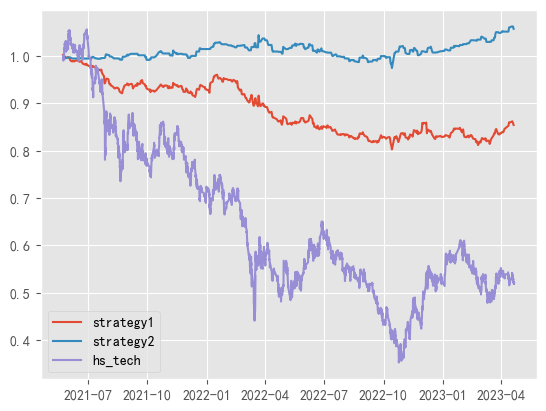

In [28]:
HSTECH_ts_recent = HSTECH_ts
ret_ts = HSTECH_ts_recent.groupby('DAY').apply(cal_buysell_ret_dynamically, commission)
print('成功交易天数占比：',round(100*len(ret_ts.dropna())/len(ret_ts),2), '%')
ret_ts.fillna(0, inplace=True)

cum_ret2 = np.cumprod(ret_ts + 1)
day_ret = pow(cum_ret2.iloc[-1],1/len(ret_ts)) - 1
year_ret = pow(1+day_ret,240) - 1
# 进行最大回撤计算
peak = np.maximum.accumulate(cum_ret2)
drawdowns = (peak - cum_ret2) / peak
max_drawdown = np.amax(drawdowns)
print('期间净值波动：', cum_ret2.std())
print('期间累计收益：', round((cum_ret2.iloc[-1]-1)*100,2), '%')
print('年化收益：', round(year_ret*100,2), '%')
print('最大回撤：', round(max_drawdown*100,2), '%')
print('shape ratio：', ((cum_ret2.iloc[-1]-1)-0.03)/cum_ret2.std())
print('收益回撤比：', (cum_ret2.iloc[-1]-1)/max_drawdown)

# cum_ret.plot()
# plt.axvline(x=datetime.datetime(2022,11,10), linestyle=":", color="m")
# plt.axvline(x=datetime.datetime(2023,2,5), linestyle=":", color="m")
# plt.axvline(x=datetime.datetime(2023,3,15), linestyle=":", color="m")
plt.plot(cum_ret.index, cum_ret, label = 'strategy1')
plt.plot(cum_ret2.index, cum_ret2, label = 'strategy2')
plt.plot(HSTECH_ts['日期'], HSTECH_ts['收盘价(元)']/HSTECH_ts['收盘价(元)'].iloc[0], label = 'hs_tech')
plt.legend(loc="best")